In [3]:
import torch
import skimage.io as io
import clip
from PIL import Image
import pickle
import json
import os
from tqdm import tqdm
import argparse
import pandas as pd

In [6]:
data = pd.read_csv("all_data/train/radiologytraindata.csv")

In [7]:
print("%0d captions loaded from json " % len(data))

65450 captions loaded from json 


In [8]:
data.head()

,id,name,caption
0,ROCO_00002,PMC4083729_AMHSR-4-14-g002.jpg,Computed tomography scan in axial view showin...
1,ROCO_00003,PMC2837471_IJD2009-150251.001.jpg,Bacterial contamination occurred after comple...
2,ROCO_00004,PMC2505281_11999_2007_30_Fig6_HTML.jpg,The patient had residual paralysis of the han...
3,ROCO_00005,PMC3745845_IJD2013-683423.005.jpg,Panoramic radiograph after immediate loading.\n
4,ROCO_00007,PMC4917066_amjcaserep-17-301-g001.jpg,Plain abdomen x-ray: Multiple air levels at t...


In [14]:
for i in tqdm(range(len(data[:5]))):
        d = data.iloc[i]
        img_id = d["name"]
        filename = f"all_data/train/images/{img_id}"
        print(filename)

100%|██████████| 5/5 [00:00<00:00, 2576.04it/s]

all_data/train/images/PMC4083729_AMHSR-4-14-g002.jpg
all_data/train/images/PMC2837471_IJD2009-150251.001.jpg
all_data/train/images/PMC2505281_11999_2007_30_Fig6_HTML.jpg
all_data/train/images/PMC3745845_IJD2013-683423.005.jpg
all_data/train/images/PMC4917066_amjcaserep-17-301-g001.jpg


In [15]:
image = io.imread(filename)

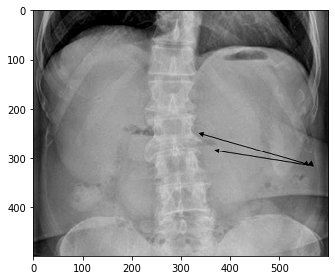

In [17]:
io.imshow(image)

### Final script; only put final edits here

In [ ]:
import torch
import skimage.io as io
import clip
from PIL import Image
import pickle
import json
import os
from tqdm import tqdm
import argparse
import pandas as pd


def main(clip_model_type: str):
    device = torch.device('cuda:0')
    clip_model_name = clip_model_type.replace('/', '_')
    out_path = f"./clip/roco/{clip_model_name}_train.pkl"
    clip_model, preprocess = clip.load(clip_model_type, device=device, jit=False)
    #all_data/train
    data = pd.read_csv("all_data/train/radiologytraindata.csv")
#     with open('.all_data/train/radiologytrain_caption.json', 'r') as f:
#         data = json.load(f)
    print("%0d captions loaded from json " % len(data))
    all_embeddings = []
    all_captions = []
    for i in tqdm(range(len(data))):
        d = data.iloc[i]
        img_id = d["name"]
        filename = f"all_data/train/images/{img_id}"
#         if not os.path.isfile(filename):
#             filename = f"./data/coco/val2014/COCO_val2014_{int(img_id):012d}.jpg"
        image = io.imread(filename)
        image = preprocess(Image.fromarray(image)).unsqueeze(0).to(device)
        with torch.no_grad():
            prefix = clip_model.encode_image(image).cpu()
        d["clip_embedding"] = i
        all_embeddings.append(prefix)
        all_captions.append(d)
        if (i + 1) % 10000 == 0:
            with open(out_path, 'wb') as f:
                pickle.dump({"clip_embedding": torch.cat(all_embeddings, dim=0), "captions": all_captions}, f)

    with open(out_path, 'wb') as f:
        pickle.dump({"clip_embedding": torch.cat(all_embeddings, dim=0), "captions": all_captions}, f)

    print('Done')
    print("%0d embeddings saved " % len(all_embeddings))
    return 0


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--clip_model_type', default="ViT-B/32", choices=('RN50', 'RN101', 'RN50x4', 'ViT-B/32'))
    args = parser.parse_args()
    exit(main(args.clip_model_type))